Score: 3653 at -0.0999999999999992 and 480
Score: 5933 at -0.24999999999999933 and 270
Score: 6576 at 0.4500000000000013 and 60
Score: 3335 at 0.9000000000000017 and 120
Score: 2241 at 0.6000000000000014 and 0
Score: 1056 at -0.7999999999999998 and 480
Score: 2694 at 0.9000000000000017 and 120
Score: 1644 at -0.6499999999999997 and 330
Score: 2599 at -0.7499999999999998 and 480
Score: 1438 at 0.6000000000000014 and 360
Score: 1859 at 0.9000000000000017 and 60
Score: 2595 at -0.95 and 330
Score: 2264 at -0.95 and 480
Score: 1745 at 0.9000000000000017 and 120
Score: 4196 at -0.5999999999999996 and 390
Score: 7976 at -0.6999999999999997 and 480
Score: 4912 at 0.6500000000000015 and 0
Score: 6003 at -0.2999999999999994 and 450
Score: 1537 at 0.7000000000000015 and 0
Score: 860 at -0.14999999999999925 and 480


/tmp/ipykernel_4047/3413703073.py:149: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 6))


Score: 2007 at -0.39999999999999947 and 270
Score: 1176 at -0.14999999999999925 and 120
Score: 1374 at -0.39999999999999947 and 330
Score: 1257 at 0.8500000000000016 and 270
Score: 1314 at -0.95 and 450
Score: 1157 at 0.8000000000000016 and 30
Score: 1096 at -0.6999999999999997 and 480
Score: 2598 at -0.24999999999999933 and 480
Score: 1388 at 0.30000000000000115 and 0
Score: 1732 at -0.3499999999999994 and 450
Score: 4725 at -0.6999999999999997 and 480
Score: 2897 at -0.0999999999999992 and 180
Score: 5689 at 0.6000000000000014 and 210
Score: 3619 at 0.5000000000000013 and 120
Score: 3425 at 0.40000000000000124 and 210
Score: 4136 at -0.8999999999999999 and 480
Score: 1216 at 0.4500000000000013 and 0
Score: 1606 at 0.5000000000000013 and 330
Score: 2297 at -0.8999999999999999 and 450
Score: 1248 at 0.8500000000000016 and 210
Score: 961 at 0.5000000000000013 and 0
Score: 868 at -0.5499999999999996 and 480
Score: 841 at 0.5500000000000014 and 210
Score: 524 at -0.1999999999999993 and 42

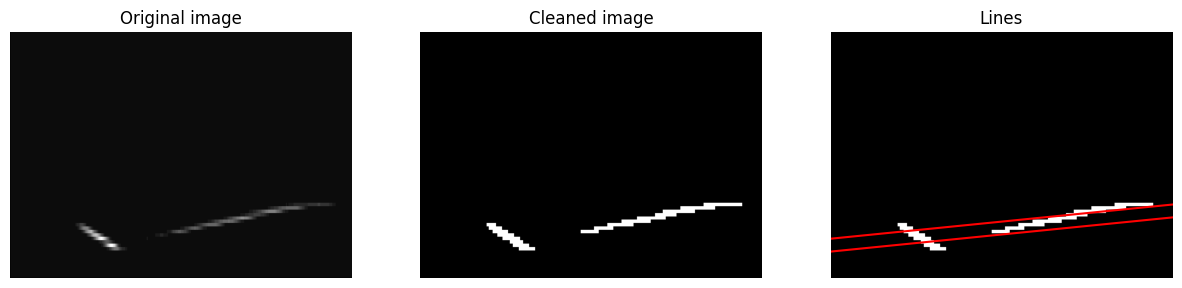

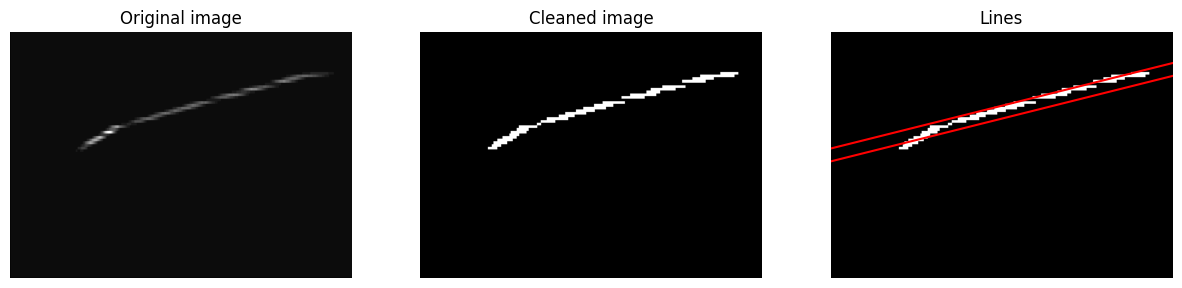

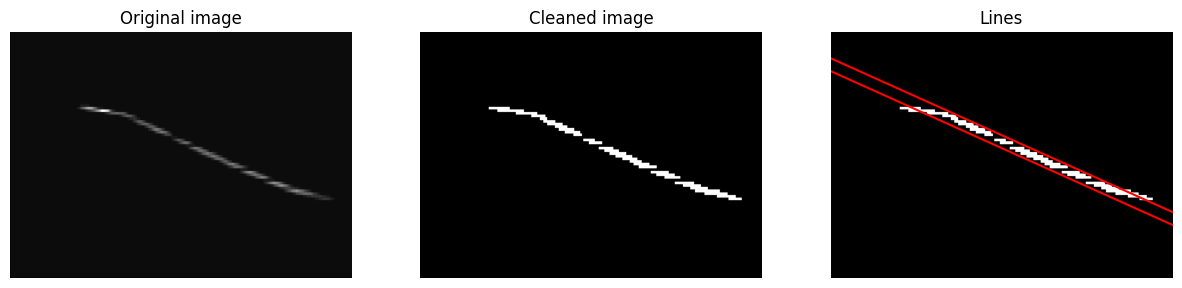

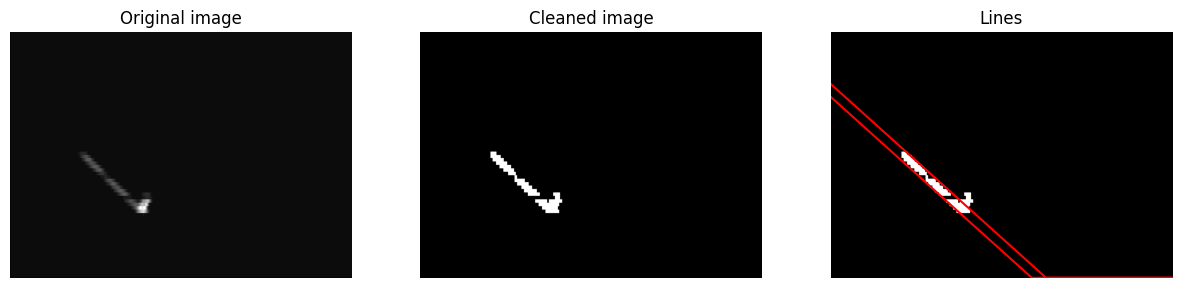

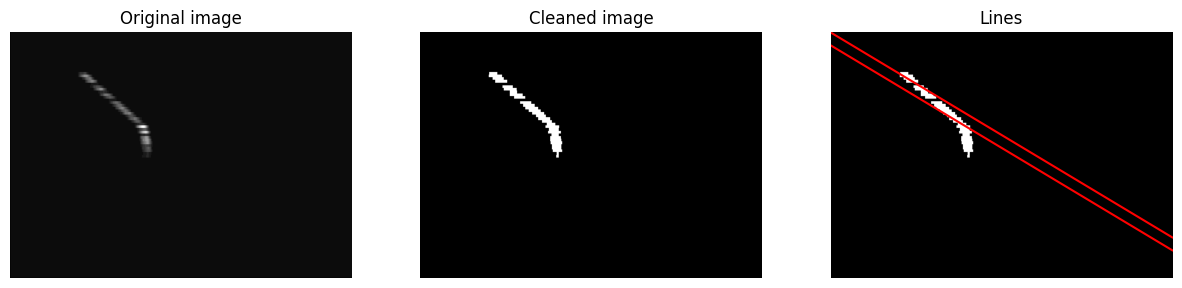

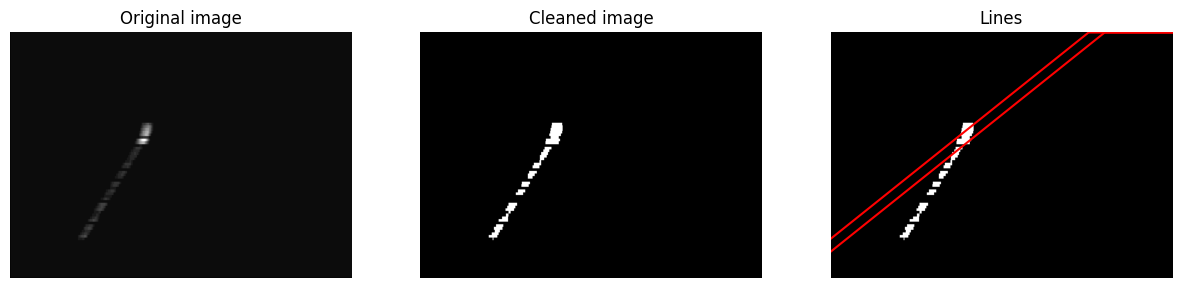

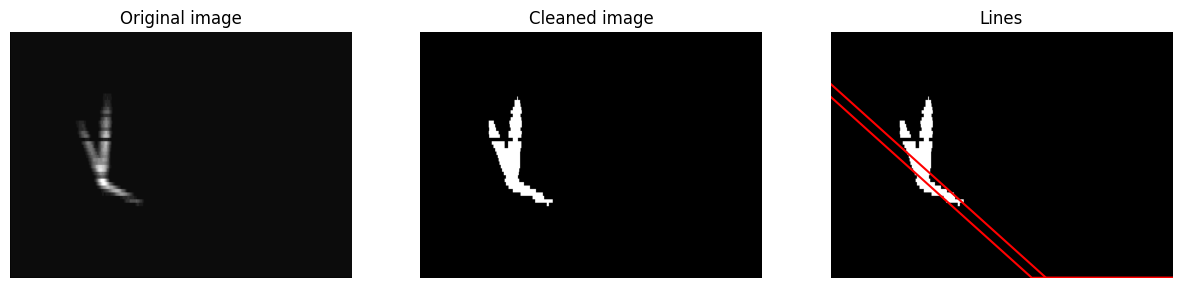

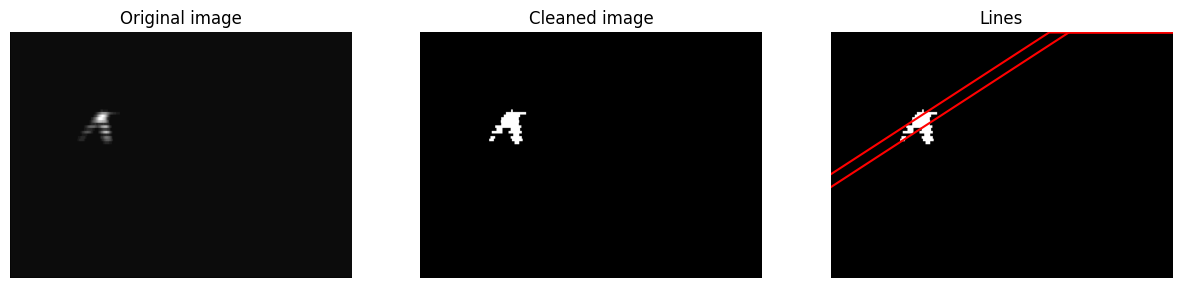

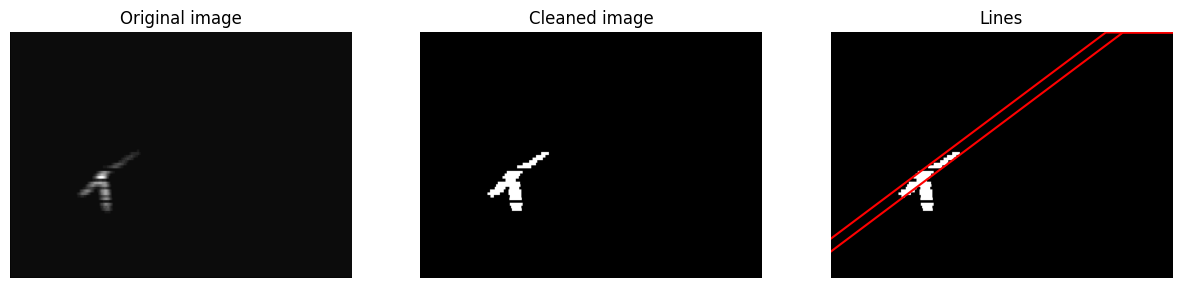

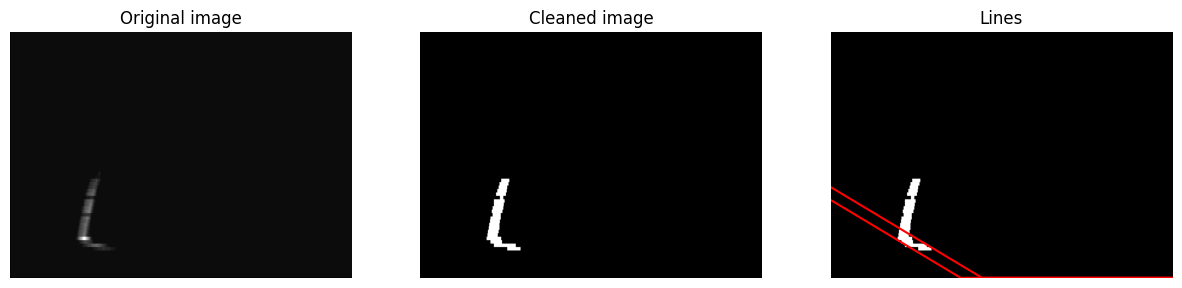

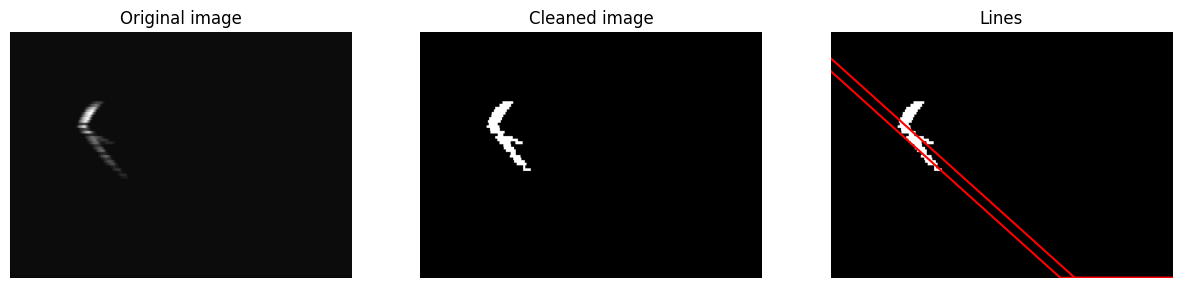

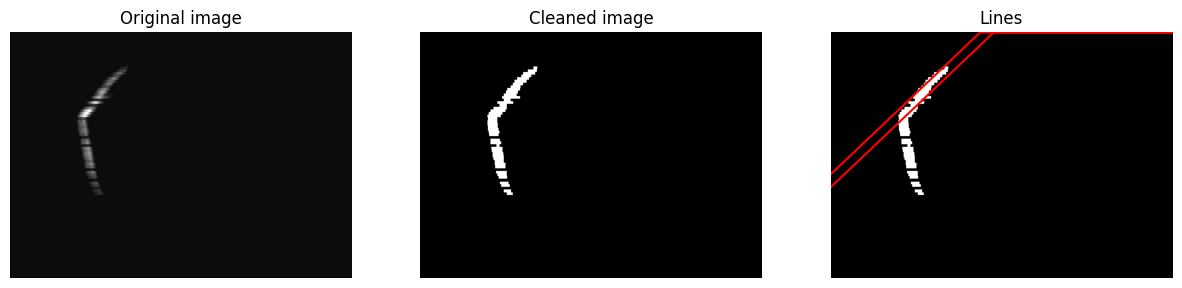

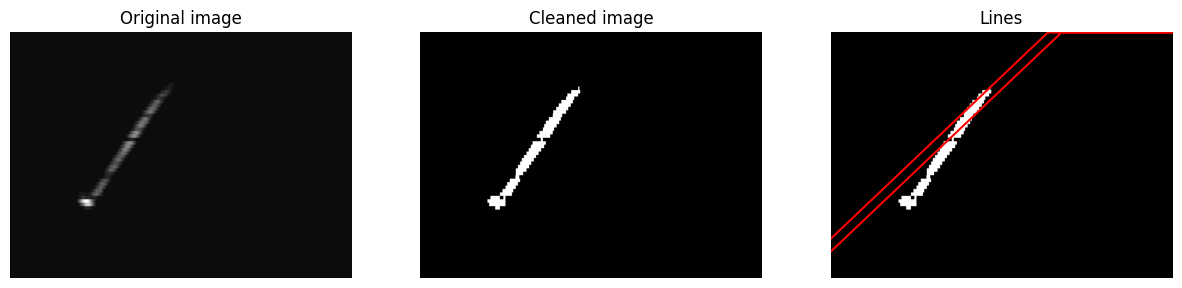

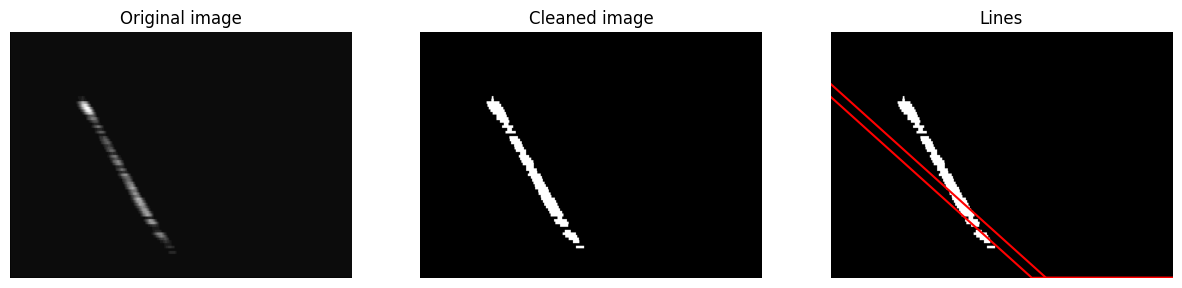

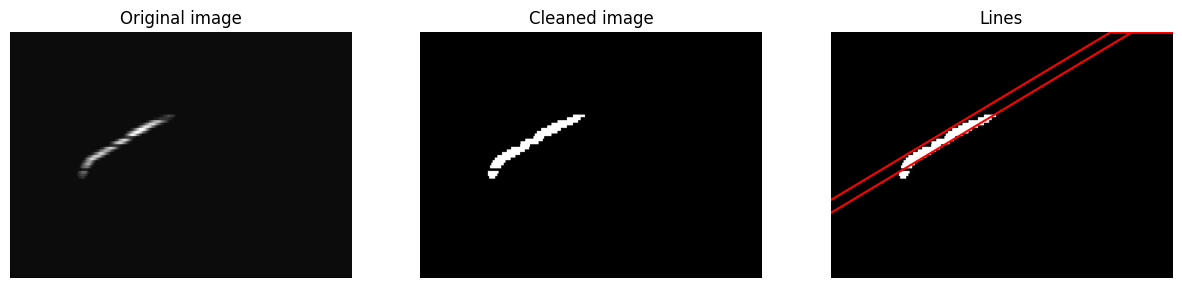

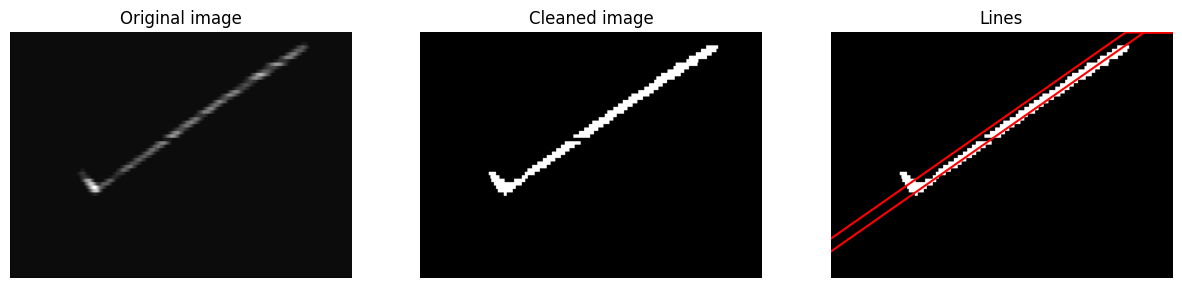

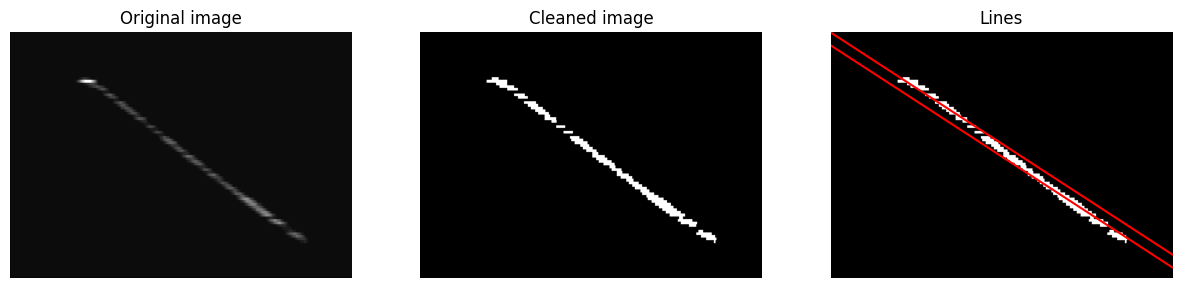

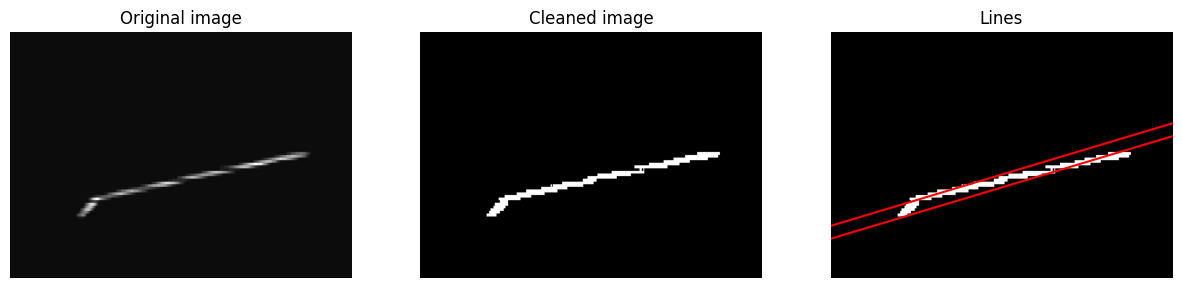

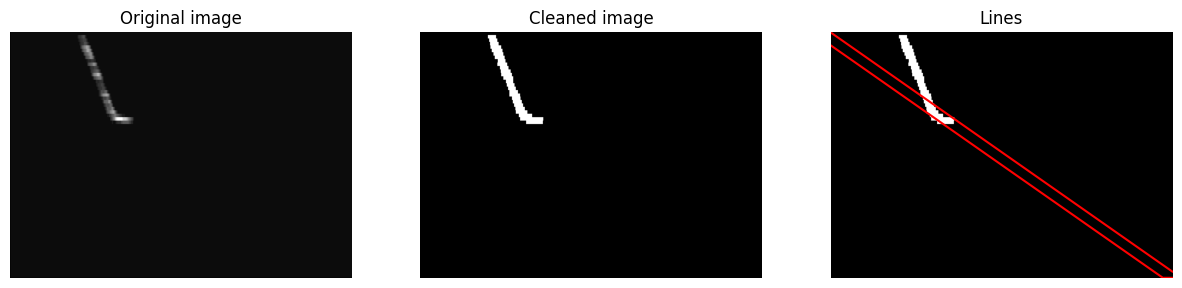

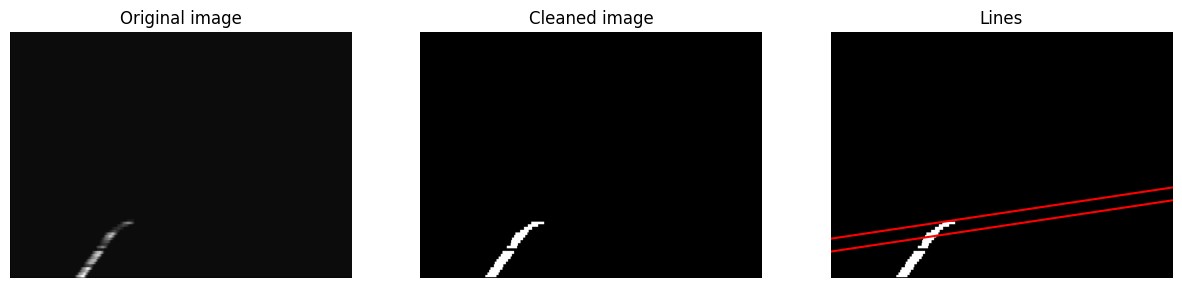

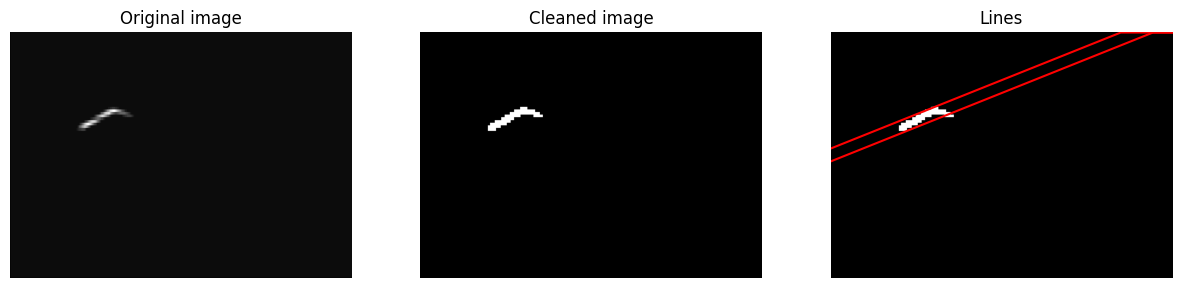

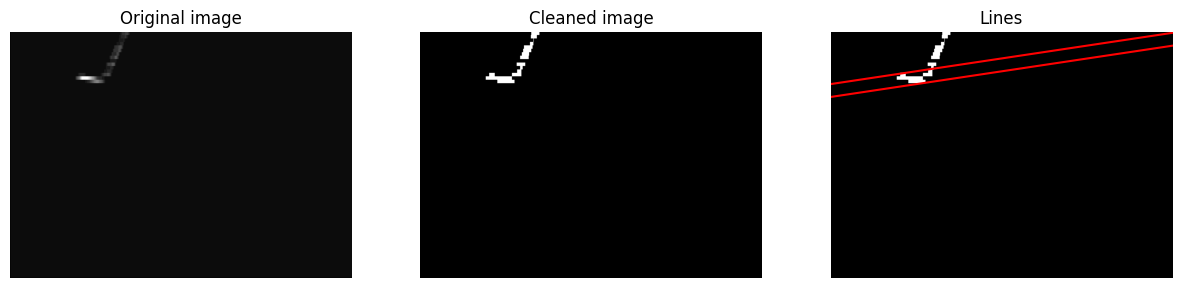

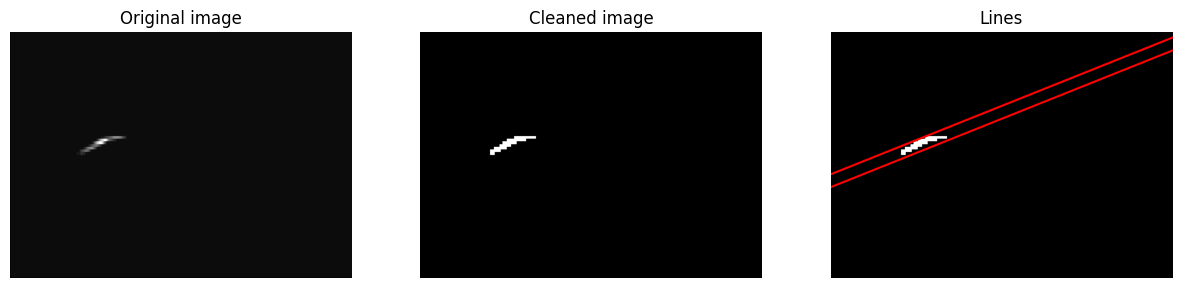

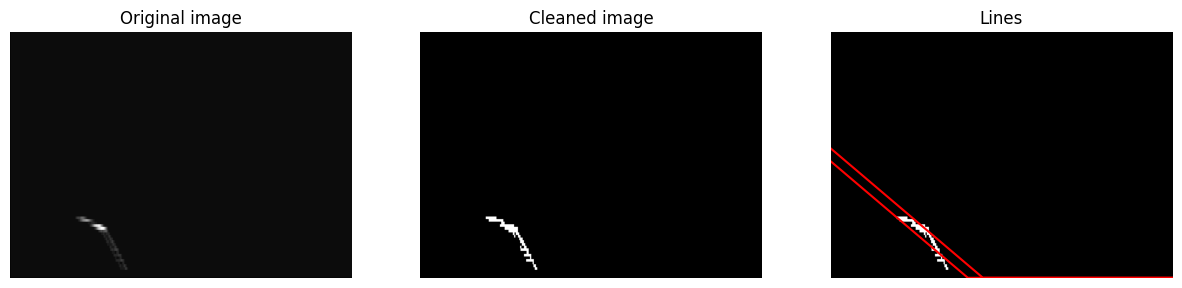

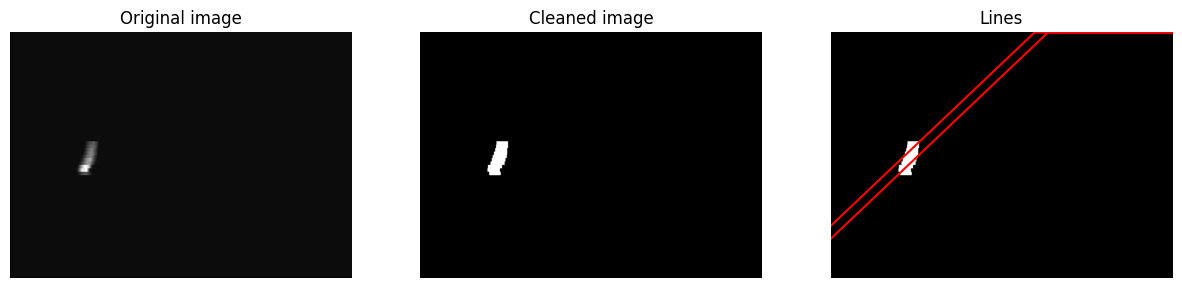

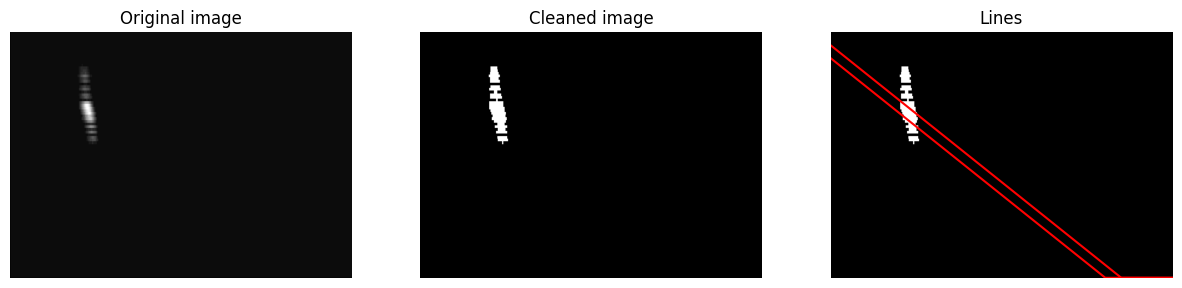

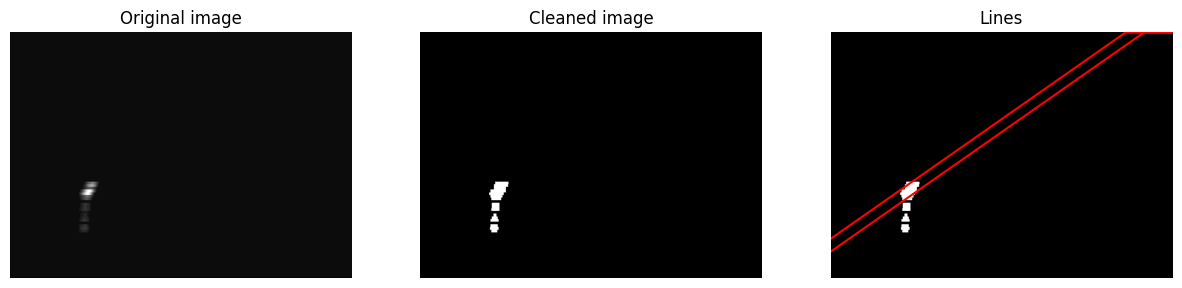

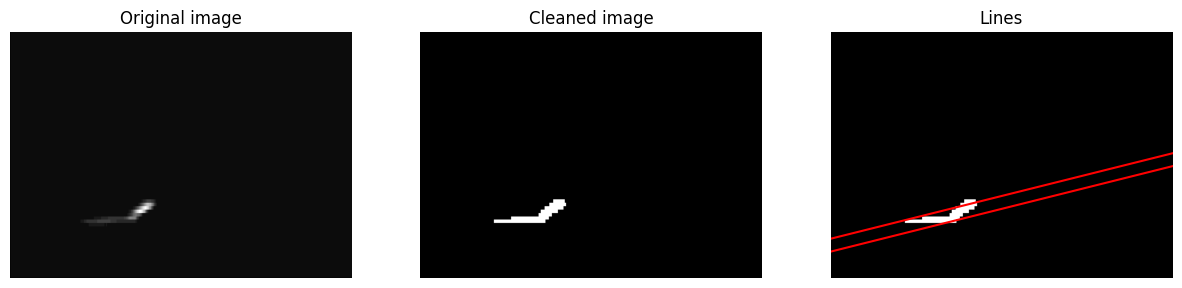

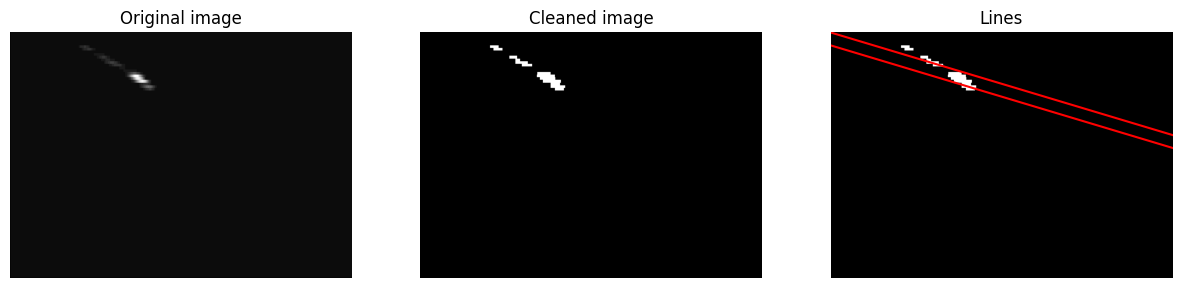

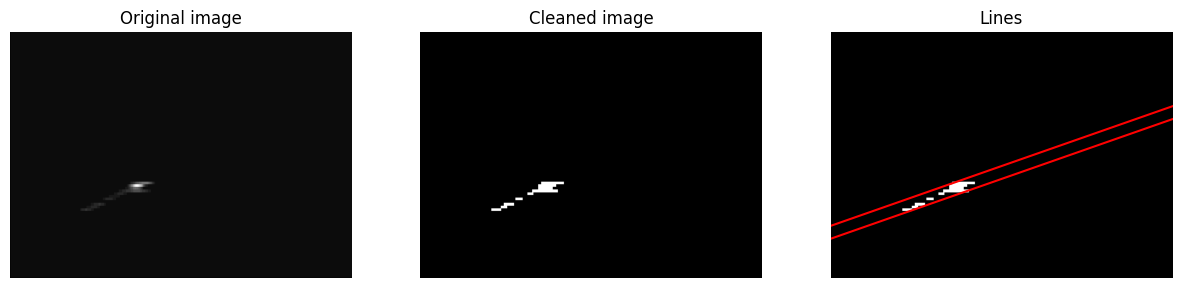

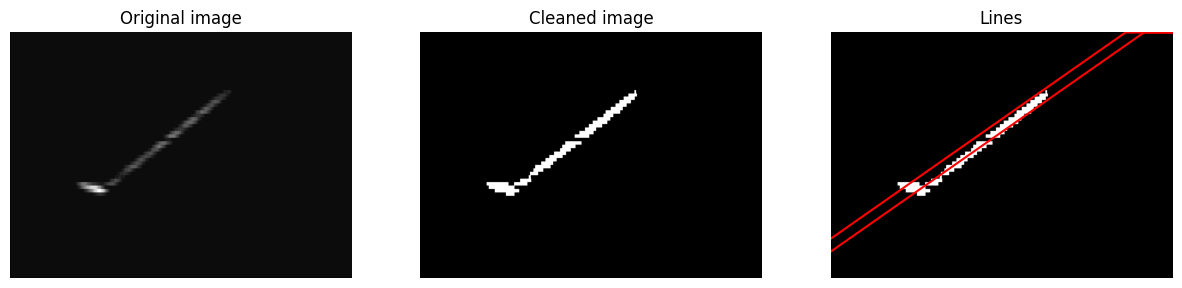

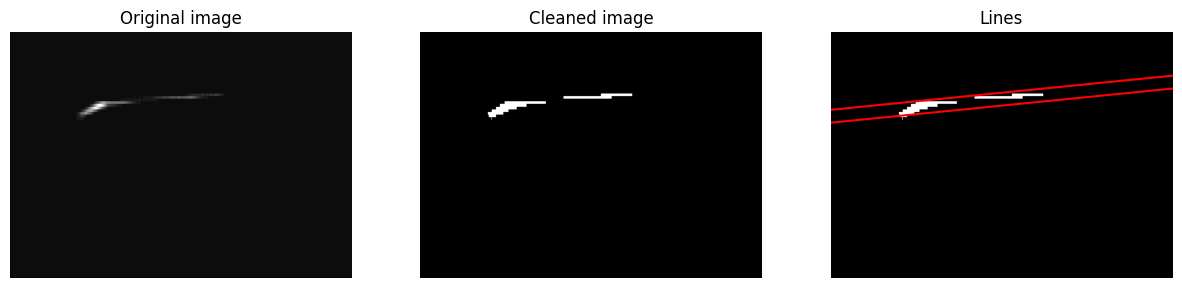

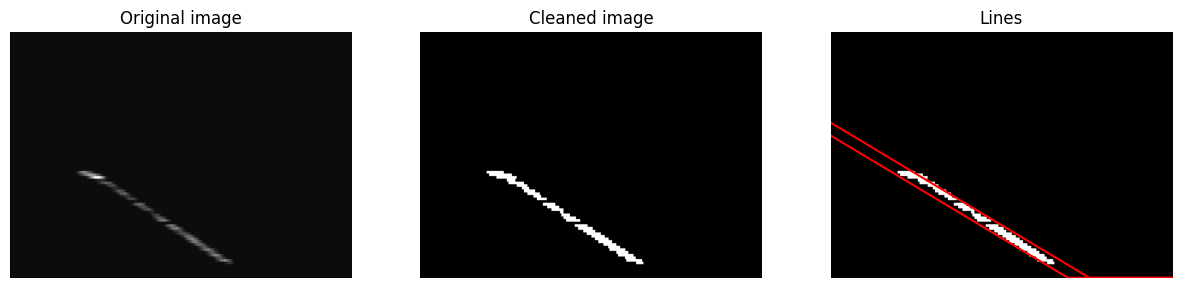

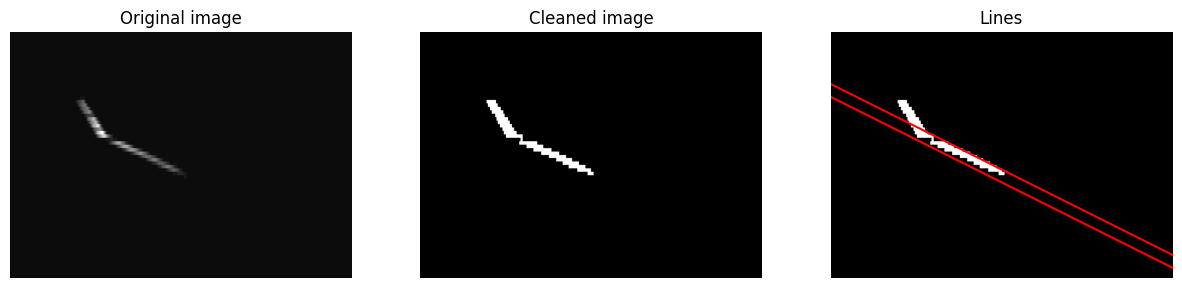

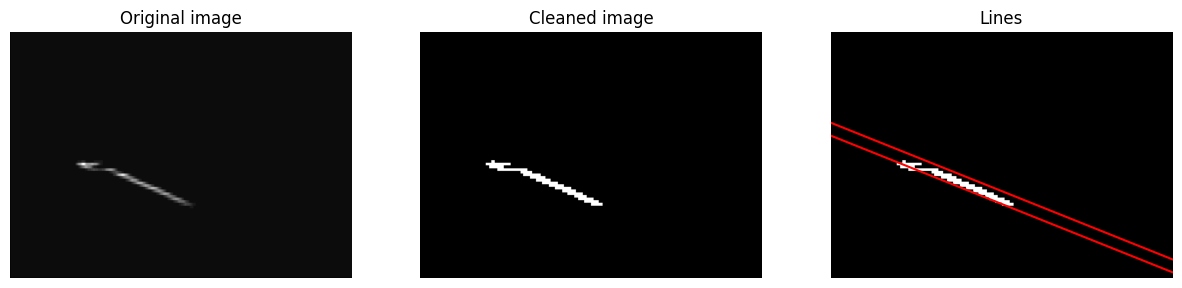

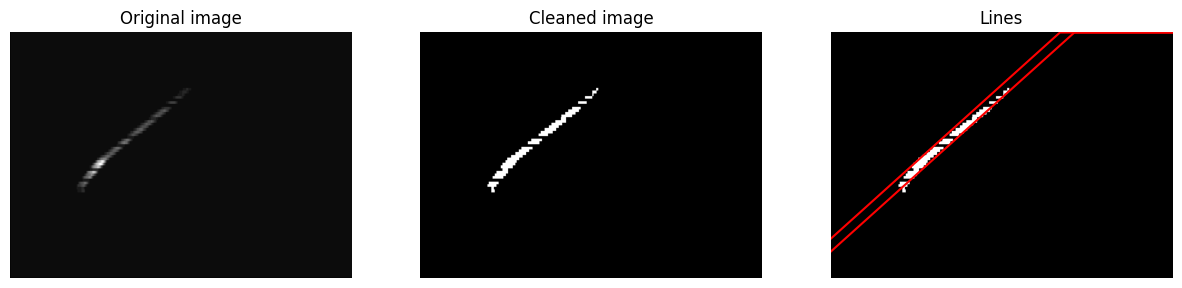

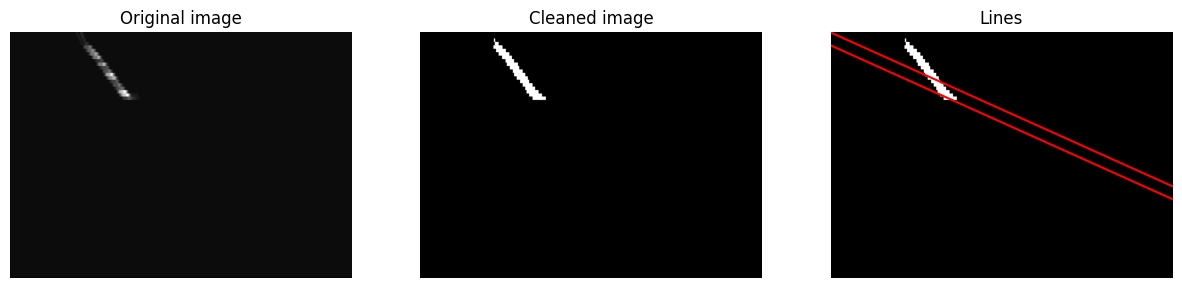

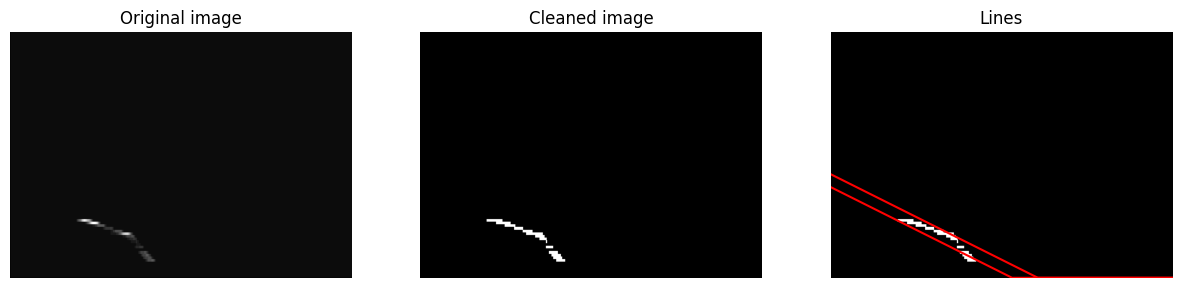

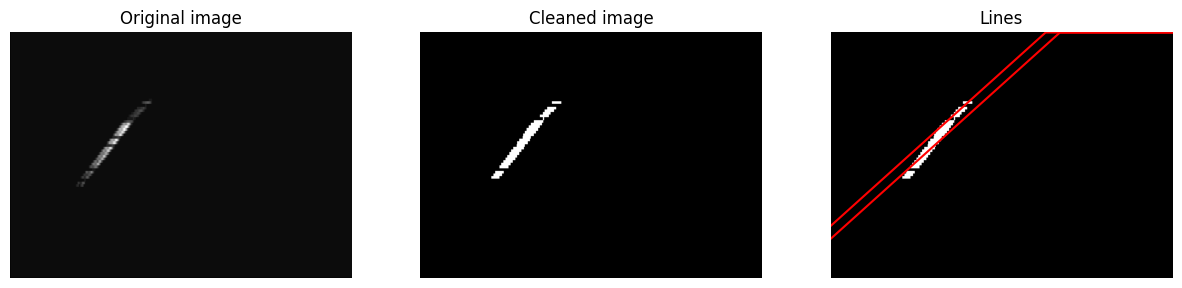

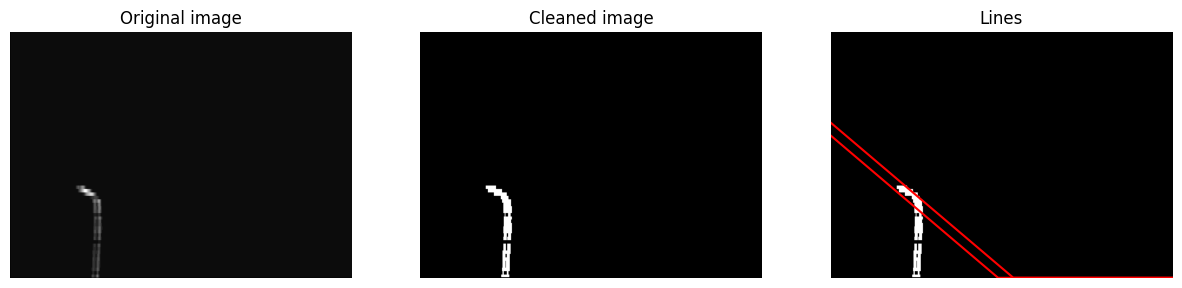

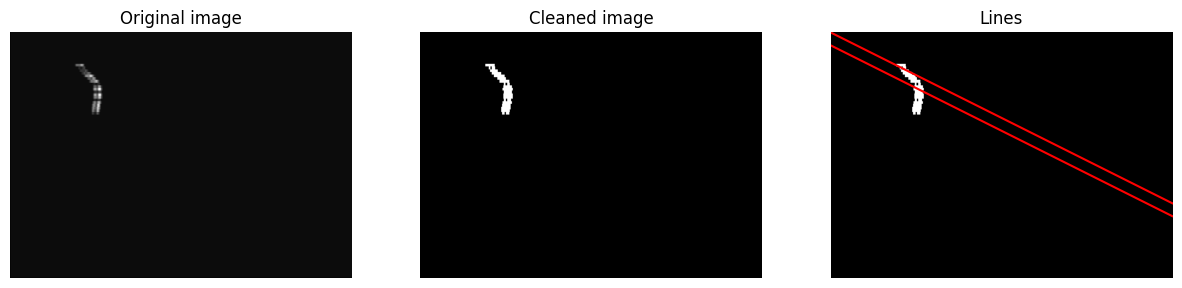

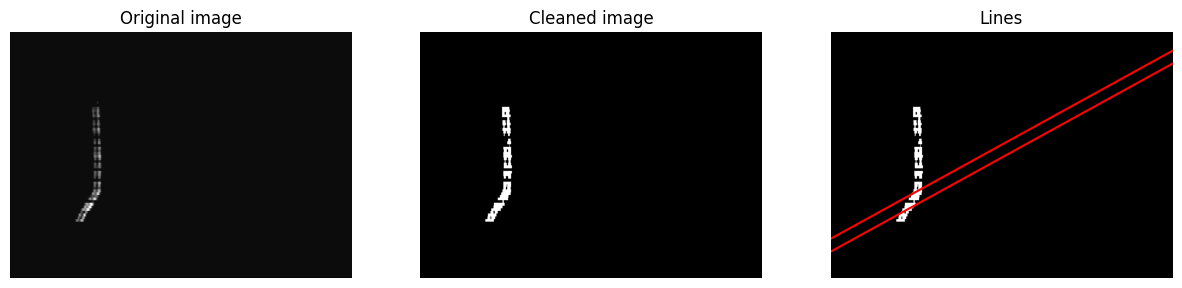

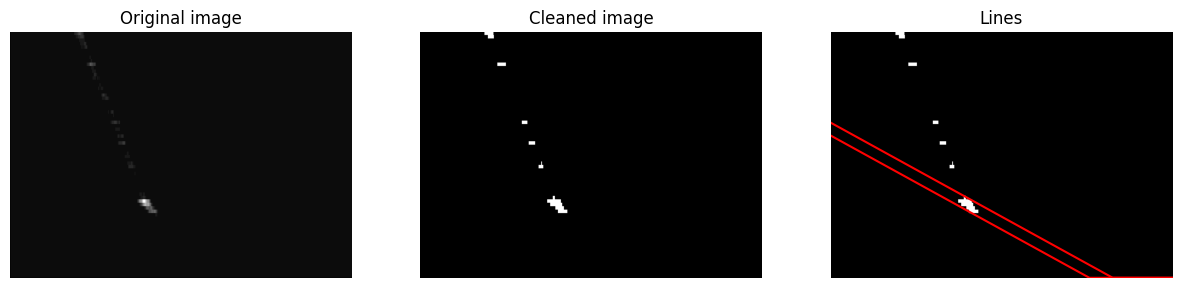

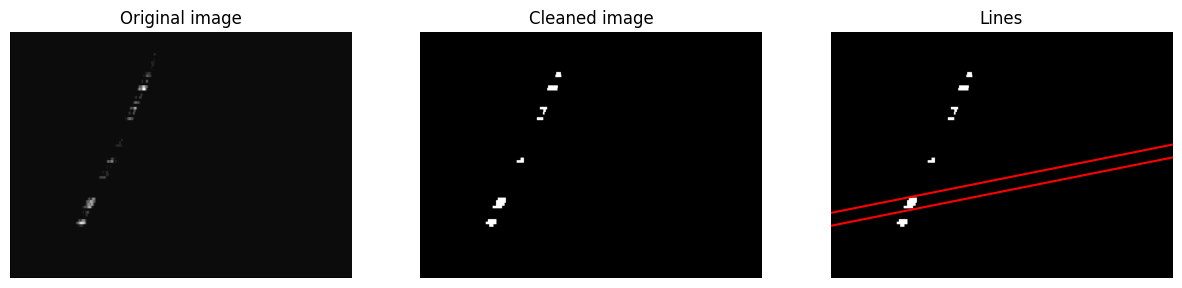

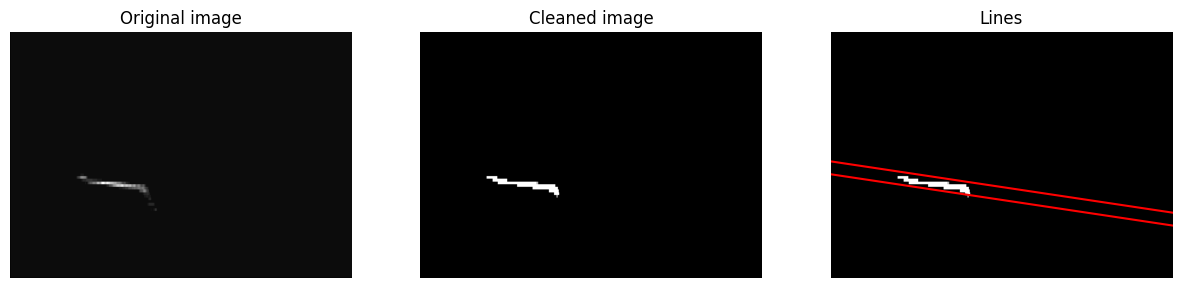

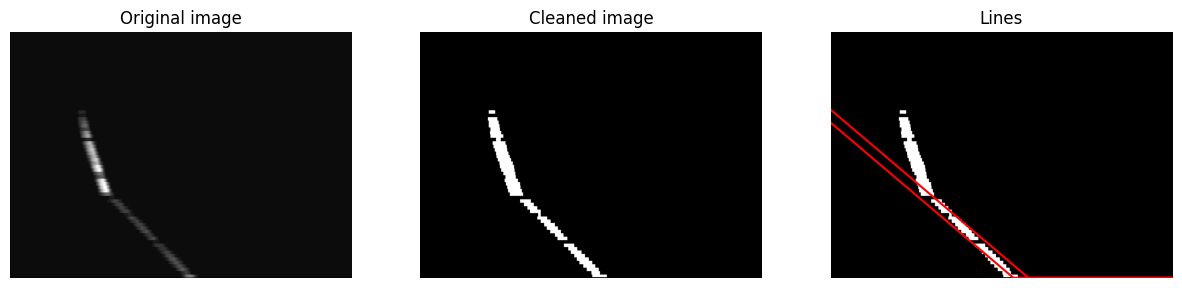

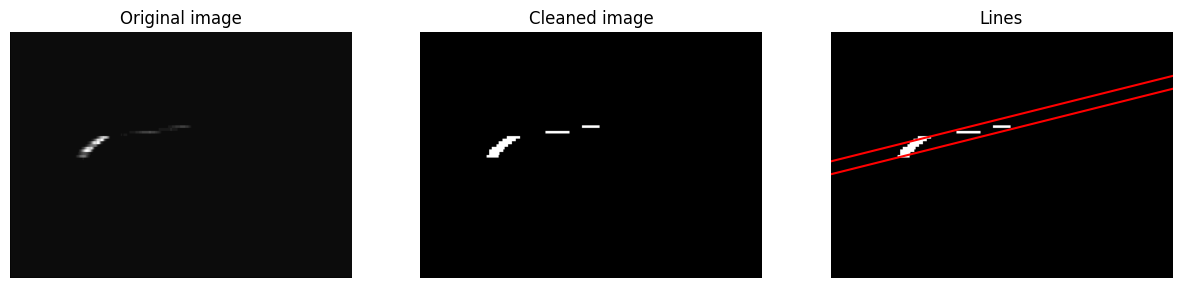

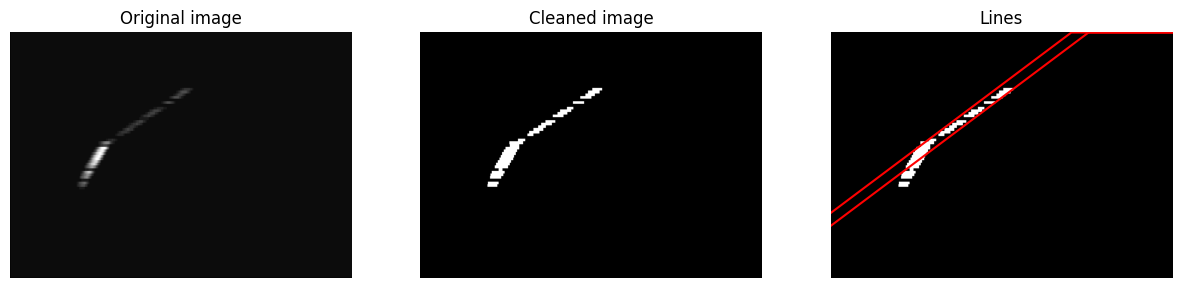

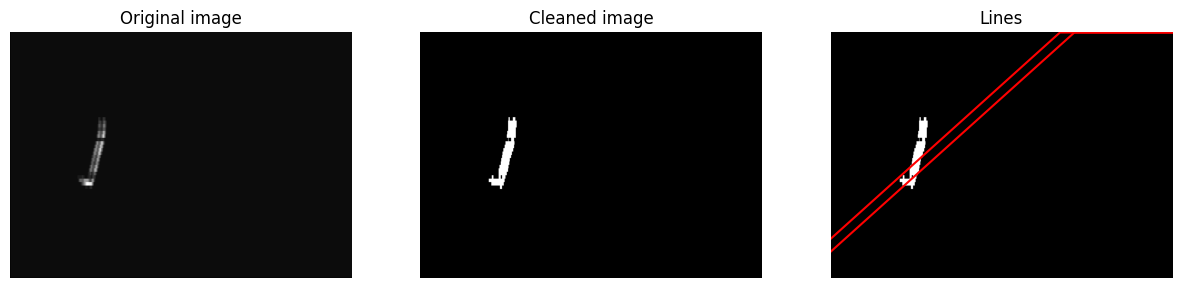

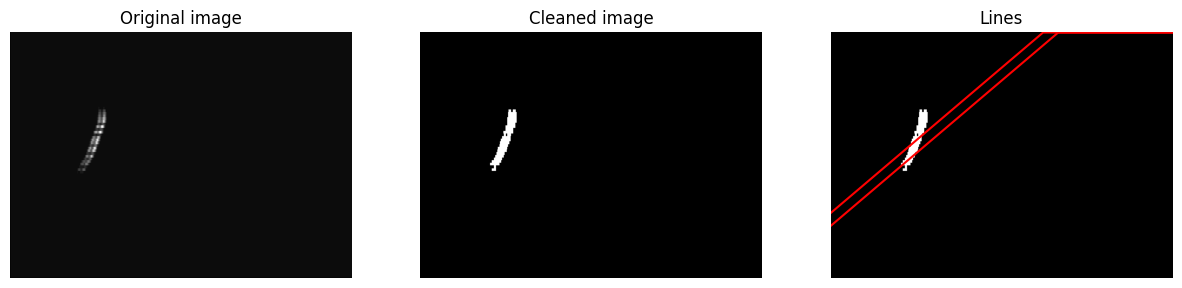

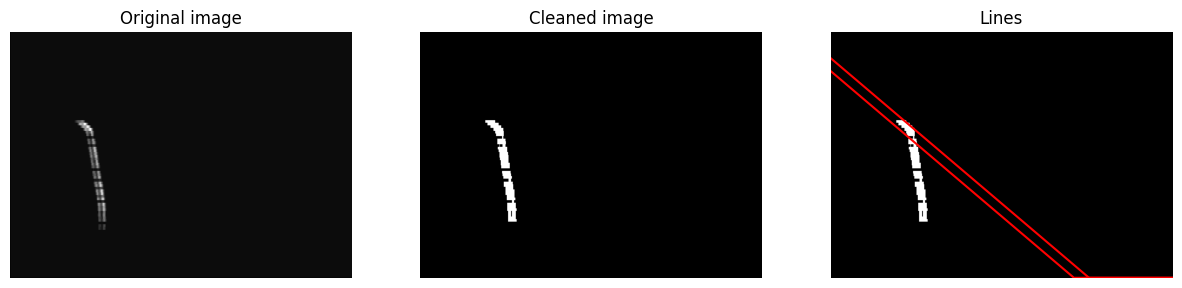

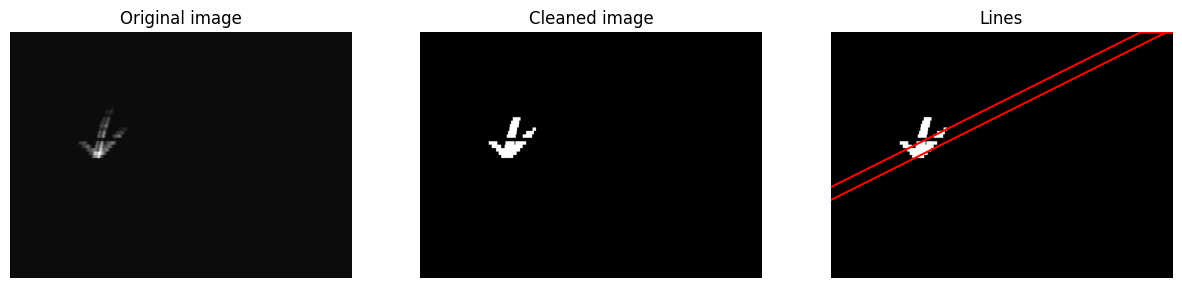

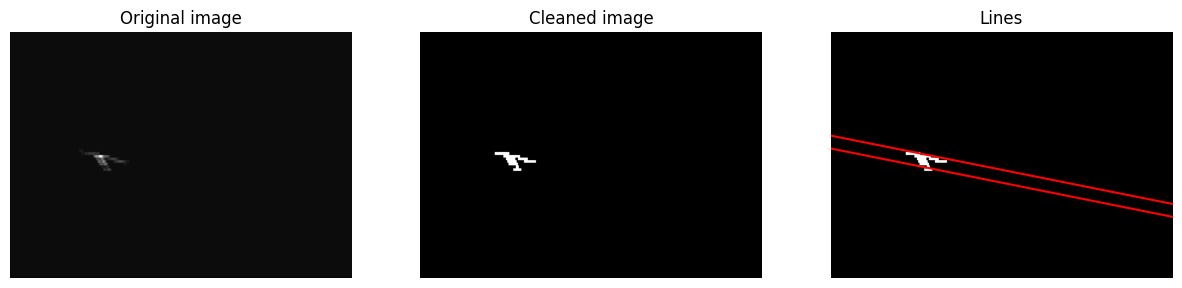

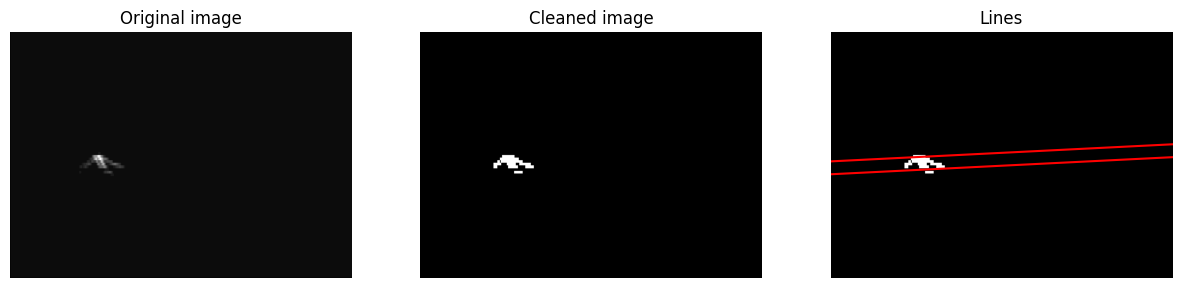

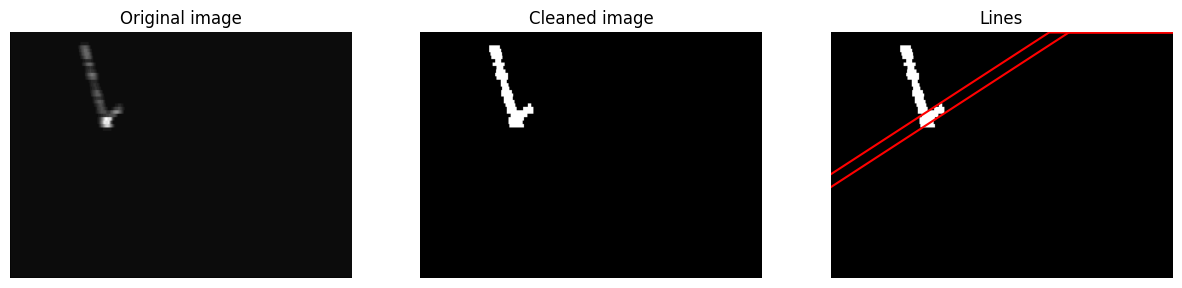

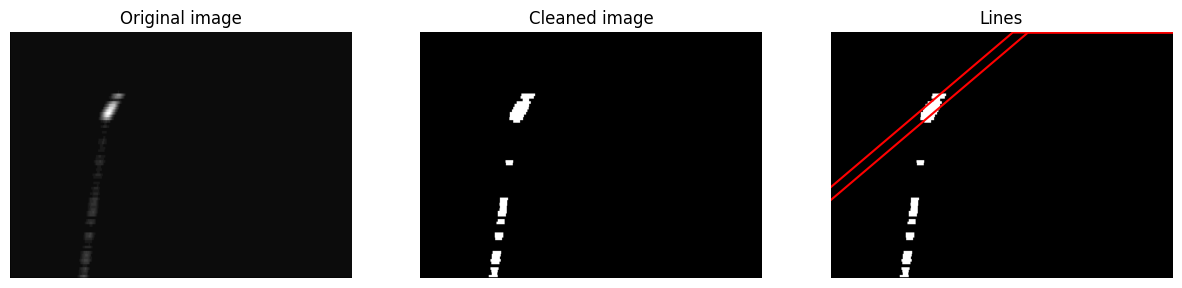

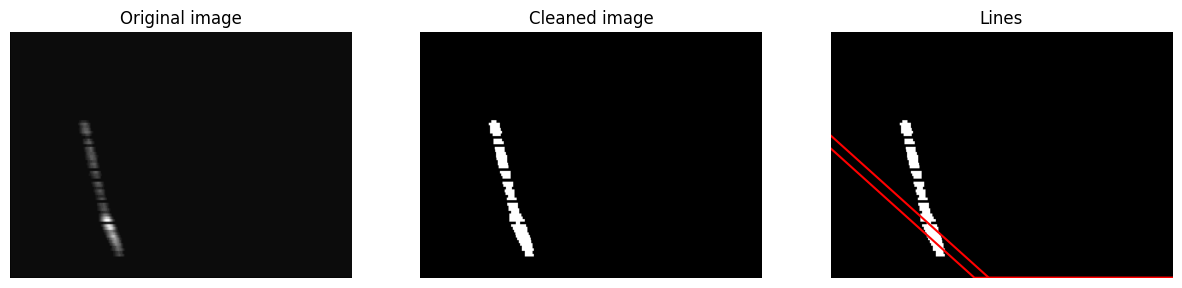

In [79]:
from skimage.measure import LineModelND, ransac
from skimage.color import rgb2gray
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from src.openImage import openImage

from skimage.transform import hough_line, hough_line_peaks


# Remove small shapes.
def cleanNoise(image, min_size_threshold=100):

    # Apply a different label for each shape.
    labeled_image, num_labels = ndimage.label(image)

    # Count the size of each labes which is the size of each shape. Remember to address the fact that 0 is not a real label and is background.
    sizes = np.bincount(labeled_image.ravel())

    # Exclude the background label (0) from the sizes array.
    sizes[0] = 0

    # Remove small connected components
    filtered_image = np.where(sizes[labeled_image] < min_size_threshold, 0, 1)

    return filtered_image


def cutTenPixels(data):
    #Only for BAD_ folder

    height, width= data.shape

    # Set the border pixels to 0
    data[:10, :] = 0  # Top border
    data[height-10:, :] = 0  # Bottom border
    data[:, :10] = 0  # Left border
    data[:, width-10:] = 0  # Right border

    return data


def countWhitePixels(image, slope, intercept, width):
    # Count the pixels between the lines

    # Generate parallel lines
    x_values = np.arange(image.shape[1])
    line1_y = slope * x_values + intercept
    line2_y = slope * x_values + intercept + width

    # Ensure that line1_y and line2_y are within the bounds of the image
    line1_y = np.clip(line1_y, 0, image.shape[0] - 1)
    line2_y = np.clip(line2_y, 0, image.shape[0] - 1)

    # Round the y-values to integers
    line1_y_int = np.round(line1_y).astype(int)
    line2_y_int = np.round(line2_y).astype(int)
    
    # Find the minimum and maximum y-values for each column
    min_y = np.minimum(line1_y_int, line2_y_int)
    max_y = np.maximum(line1_y_int, line2_y_int)
    
    # Create a mask for the region between the lines
    mask = np.zeros_like(image, dtype=bool)
    for col in range(image.shape[1]):
        mask[min_y[col]:max_y[col]+1, col] = True
    
    # Count white pixels between the lines
    white_pixels = np.sum(image[mask])

    #print(f"White pixels = {white_pixels}")

    return white_pixels


def findBestSegment(image, segment_width = 30):
    max_score = 0
    optimal_intercept = 0
    optimal_slope = 0

    for slope in np.arange(-0.95, 0.95, 0.05):
        for intercept in np.arange(0, 500, 30):
        
            loc_score = countWhitePixels(image, slope, intercept, segment_width)
            if(loc_score > max_score):
                max_score = loc_score
                optimal_slope = slope
                optimal_intercept = intercept

    print(f"Score: {max_score} at {optimal_slope} and {optimal_intercept}")

    return optimal_slope, optimal_intercept, max_score

 

def removeInlierPoints(image, slope, intercept, width):
    # Remove the pixels between the lines

    # Generate parallel lines
    x_values = np.arange(image.shape[1])
    line1_y = slope * x_values + intercept
    line2_y = slope * x_values + intercept + width

    # Ensure that line1_y and line2_y are within the bounds of the image
    line1_y = np.clip(line1_y, 0, image.shape[0] - 1)
    line2_y = np.clip(line2_y, 0, image.shape[0] - 1)

    # Round the y-values to integers
    line1_y_int = np.round(line1_y).astype(int)
    line2_y_int = np.round(line2_y).astype(int)
    
    # Find the minimum and maximum y-values for each column
    min_y = np.minimum(line1_y_int, line2_y_int)
    max_y = np.maximum(line1_y_int, line2_y_int)
    
    # Create a mask for the region between the lines
    mask = np.zeros_like(image, dtype=bool)
    for col in range(image.shape[1]):
        mask[min_y[col]:max_y[col]+1, col] = True
    
    # Remove white pixels between the lines
    image[mask] = 0



    return image


def fitImage(path_and_name_input, path_and_name_output=None):

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    original_image = test_image.m_data

    test_image.m_data = rgb2gray(test_image.m_data)
    test_image.m_data = np.where(test_image.m_data < 0.15, 0, 1)

    #########################################
    ########### FOR WHITE BORDER ############
    #test_image.m_data = cutTenPixels(test_image.m_data)
    #########################################
    #########################################

    test_image.m_data = cleanNoise(test_image.m_data, 100)


    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title('Original image')
    ax[0].set_axis_off()

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title('Cleaned image')
    ax[1].set_axis_off()

    ax[2].imshow(test_image.m_data, cmap=cm.gray)
    ax[2].set_title('Lines')
    ax[2].set_axis_off()

    segment_width = 30
    min_points = 50
    max_lines = 1

    fit_data = test_image.m_data
    

    lines_eq = []

    for i in range(max_lines):

        points = np.argwhere(fit_data == 1)[:, ::-1]

        if(len(points) < min_points):
            break

        #print(f"Points: {len(points)}")

        optimal_slope, optimal_intercept, score = findBestSegment(fit_data, segment_width)

        fit_data = removeInlierPoints(fit_data, optimal_slope, optimal_intercept, segment_width)

        lines_eq.append([optimal_slope, optimal_intercept])

        #print(f"Slope: {optimal_slope}\nIntercept: {optimal_intercept}\nScore: {score}\n")

    
    for slope, intercept in lines_eq:

        x1 = np.arange(0, test_image.m_data.shape[1])
        y1 = slope * x1 + intercept

        x2 = np.arange(0, test_image.m_data.shape[1])
        y2 = slope * x1 + intercept + 30

        y1_clipped = np.clip(y1, 0, test_image.m_data.shape[0]-1)
        y2_clipped = np.clip(y2, 0, test_image.m_data.shape[0]-1) 

        ax[2].plot(x1, y1_clipped, label=f"Fitted line", color='red')
        ax[2].plot(x2, y2_clipped, label=f"Fitted line", color='red') 

    


#image = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/BAD_cleanimages_bw_fpn_and_smooth/CoBo_2018-06-20T10-51-39.459_0000/25_u.png"
#image = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages_bw/CoBo_2018-06-20T10-51-39.459_0000/25_u.png"
        
image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages_bw/"

image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages2/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))



